In [19]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

from keras import models
from keras import layers

from plot import PlotAx, STYLE_PATH
from data_loader import LoaderCrisL1
from util import get_cris_full_train_data, get_range_index, rad2tbb

%matplotlib inline

设置需要测量通道的范围和预测通道的范围

In [20]:
in_dir = '/home/cali/data/GapFilling/CRISFull/'
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames]
in_files.sort()

# ranges_X = [(650., 1095.), (1210., 1750.), (2155., 2550.)]
# ranges_Y = [(1095.625, 1209.375), (1750.625, 2154.375), (2550.625, 2755.)]

# ranges_X = [(650., 1095.), (1210., 1750.), (2155., 2550.)]
# ranges_Y = [(1095.625, 1209.375)]

ranges_X = [(650., 1095), ]
ranges_Y = [(1095.625, 1209.375), ]

# ranges_X = [(1210., 1750), ]
# ranges_Y = [(1750.625, 2154.375), ]

# ranges_X = [(2155., 2550.)]
# ranges_Y = [(2550., 2755.)]

预处理数据，将存在小于0的样本去除

In [21]:
count = None # 加载全部的数据
X, Y = get_cris_full_train_data(in_files, x_ranges=ranges_X, y_ranges=ranges_Y, count=count)

XY = pd.concat([X, Y], axis=1)
XY = XY.astype('float32')
print(XY.shape)
XY[XY <= 0] = np.nan
XY = XY.dropna(axis=0)
print(XY.shape)
X_col = X.shape[1]
Y_col = Y.shape[1]
X = XY.iloc[:, :X_col]
Y = XY.iloc[:, X_col: X_col+Y_col]

(802200, 896)
(801350, 896)


创建训练数据集和测试数据集

In [22]:
random_seed = 42
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state=random_seed, test_size=0.2)

设置训练数据集和测试数据集的大小

In [23]:
train_count = -1
test_count = -1

train_X_count = train_X.iloc[:train_count]
test_X_count = test_X.iloc[:test_count]

train_Y_count = train_Y.iloc[:train_count]
test_Y_count = test_Y.iloc[:test_count]

数据标准化

In [24]:
mean = train_X_count.mean(axis=0)
std = train_X_count.std(axis=0)
train_X_count -= mean
train_X_count /= std
test_X_count -= mean
test_X_count /= std

In [25]:
train_X_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641079 entries, 530252 to 671852
Columns: 713 entries, 0 to 712
dtypes: float32(713)
memory usage: 1.7 GB


In [26]:
test_X_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160269 entries, 745219 to 506975
Columns: 713 entries, 0 to 712
dtypes: float32(713)
memory usage: 437.1 MB


In [27]:
train_Y_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641079 entries, 530252 to 671852
Columns: 183 entries, 0 to 182
dtypes: float32(183)
memory usage: 452.4 MB


In [28]:
test_Y_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160269 entries, 745219 to 506975
Columns: 183 entries, 0 to 182
dtypes: float32(183)
memory usage: 113.1 MB


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 713)               509082    
_________________________________________________________________
dense_5 (Dense)              (None, 713)               509082    
_________________________________________________________________
dense_6 (Dense)              (None, 183)               130662    
Total params: 1,148,826
Trainable params: 1,148,826
Non-trainable params: 0
_________________________________________________________________
None
Train on 641079 samples, validate on 160269 samples
Epoch 1/900
641079/641079 [==============================] - 15s 23us/step - loss: 5.5754 - mean_squared_error: 61.0006 - val_loss: 3.5093 - val_mean_squared_error: 21.3187
Epoch 2/900
641079/641079 [==============================] - 15s 23us/step - loss: 3.5137 - mean_squared_error: 21.9254 - val_loss: 3.2830 - val_mean_squared_error: 1

641079/641079 [==============================] - 14s 22us/step - loss: 0.8929 - mean_squared_error: 1.3885 - val_loss: 0.7939 - val_mean_squared_error: 1.0556
Epoch 45/900
641079/641079 [==============================] - 14s 22us/step - loss: 0.8825 - mean_squared_error: 1.3577 - val_loss: 1.0286 - val_mean_squared_error: 1.6420
Epoch 46/900
641079/641079 [==============================] - 14s 22us/step - loss: 0.8743 - mean_squared_error: 1.3301 - val_loss: 0.8970 - val_mean_squared_error: 1.3115
Epoch 47/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.8670 - mean_squared_error: 1.3074 - val_loss: 1.2509 - val_mean_squared_error: 2.3534
Epoch 48/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.8586 - mean_squared_error: 1.2813 - val_loss: 0.8234 - val_mean_squared_error: 1.2829
Epoch 49/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.8516 - mean_squared_error: 1.2617 - val_loss: 0.9858 - val_mean_squ

Epoch 92/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.6301 - mean_squared_error: 0.6724 - val_loss: 0.5739 - val_mean_squared_error: 0.5968
Epoch 93/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.6261 - mean_squared_error: 0.6639 - val_loss: 0.5106 - val_mean_squared_error: 0.4874
Epoch 94/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.6215 - mean_squared_error: 0.6558 - val_loss: 0.7137 - val_mean_squared_error: 0.7629
Epoch 95/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.6179 - mean_squared_error: 0.6473 - val_loss: 0.5298 - val_mean_squared_error: 0.4757
Epoch 96/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.6136 - mean_squared_error: 0.6386 - val_loss: 0.7889 - val_mean_squared_error: 1.0364
Epoch 97/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.6109 - mean_squared_error: 0.6337 - val_loss: 0.5888 -

641079/641079 [==============================] - 15s 23us/step - loss: 0.5465 - mean_squared_error: 0.5046 - val_loss: 0.7581 - val_mean_squared_error: 0.9935
Epoch 140/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.5454 - mean_squared_error: 0.5028 - val_loss: 0.5870 - val_mean_squared_error: 0.5577
Epoch 141/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.5434 - mean_squared_error: 0.4976 - val_loss: 0.4616 - val_mean_squared_error: 0.4461
Epoch 142/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.5405 - mean_squared_error: 0.4922 - val_loss: 0.7651 - val_mean_squared_error: 0.9931
Epoch 143/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.5389 - mean_squared_error: 0.4886 - val_loss: 0.6058 - val_mean_squared_error: 0.5616
Epoch 144/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.5361 - mean_squared_error: 0.4834 - val_loss: 0.6376 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.4257 - mean_squared_error: 0.2917 - val_loss: 0.4204 - val_mean_squared_error: 0.2913
Epoch 187/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.4249 - mean_squared_error: 0.2906 - val_loss: 0.3436 - val_mean_squared_error: 0.2015
Epoch 188/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.4245 - mean_squared_error: 0.2904 - val_loss: 0.4597 - val_mean_squared_error: 0.3343
Epoch 189/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.4227 - mean_squared_error: 0.2884 - val_loss: 0.5343 - val_mean_squared_error: 0.5333
Epoch 190/900
641079/641079 [==============================] - 14s 22us/step - loss: 0.4218 - mean_squared_error: 0.2871 - val_loss: 0.3816 - val_mean_squared_error: 0.2528
Epoch 191/900
641079/641079 [==============================] - 14s 22us/step - loss: 0.4218 - mean_squared_error: 0.2870 - val_loss: 0.5572 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.3855 - mean_squared_error: 0.2392 - val_loss: 0.3911 - val_mean_squared_error: 0.2356
Epoch 234/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3844 - mean_squared_error: 0.2377 - val_loss: 0.4175 - val_mean_squared_error: 0.2910
Epoch 235/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3832 - mean_squared_error: 0.2359 - val_loss: 0.3522 - val_mean_squared_error: 0.1961
Epoch 236/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3822 - mean_squared_error: 0.2345 - val_loss: 0.4258 - val_mean_squared_error: 0.2641
Epoch 237/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.3807 - mean_squared_error: 0.2323 - val_loss: 0.3865 - val_mean_squared_error: 0.2674
Epoch 238/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3796 - mean_squared_error: 0.2312 - val_loss: 0.4343 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.3360 - mean_squared_error: 0.1789 - val_loss: 0.2984 - val_mean_squared_error: 0.1484
Epoch 281/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3352 - mean_squared_error: 0.1781 - val_loss: 0.2863 - val_mean_squared_error: 0.1308
Epoch 282/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3342 - mean_squared_error: 0.1771 - val_loss: 0.4031 - val_mean_squared_error: 0.2504
Epoch 283/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3323 - mean_squared_error: 0.1750 - val_loss: 0.4181 - val_mean_squared_error: 0.2843
Epoch 284/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3316 - mean_squared_error: 0.1740 - val_loss: 0.3487 - val_mean_squared_error: 0.1907
Epoch 285/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.3301 - mean_squared_error: 0.1723 - val_loss: 0.3483 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.2976 - mean_squared_error: 0.1411 - val_loss: 0.3560 - val_mean_squared_error: 0.2016
Epoch 328/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2970 - mean_squared_error: 0.1405 - val_loss: 0.3177 - val_mean_squared_error: 0.1610
Epoch 329/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2964 - mean_squared_error: 0.1400 - val_loss: 0.2680 - val_mean_squared_error: 0.1205
Epoch 330/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2954 - mean_squared_error: 0.1390 - val_loss: 0.3097 - val_mean_squared_error: 0.1532
Epoch 331/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2946 - mean_squared_error: 0.1384 - val_loss: 0.3621 - val_mean_squared_error: 0.2120
Epoch 332/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2941 - mean_squared_error: 0.1380 - val_loss: 0.3069 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.2635 - mean_squared_error: 0.1117 - val_loss: 0.2538 - val_mean_squared_error: 0.1074
Epoch 375/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2625 - mean_squared_error: 0.1107 - val_loss: 0.3017 - val_mean_squared_error: 0.1403
Epoch 376/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2620 - mean_squared_error: 0.1102 - val_loss: 0.2754 - val_mean_squared_error: 0.1179
Epoch 377/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2612 - mean_squared_error: 0.1097 - val_loss: 0.2381 - val_mean_squared_error: 0.0916
Epoch 378/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2606 - mean_squared_error: 0.1093 - val_loss: 0.3035 - val_mean_squared_error: 0.1378
Epoch 379/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2602 - mean_squared_error: 0.1090 - val_loss: 0.3235 - val_mea

641079/641079 [==============================] - 15s 24us/step - loss: 0.2440 - mean_squared_error: 0.0957 - val_loss: 0.2133 - val_mean_squared_error: 0.0763
Epoch 422/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2437 - mean_squared_error: 0.0955 - val_loss: 0.2155 - val_mean_squared_error: 0.0764
Epoch 423/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2434 - mean_squared_error: 0.0952 - val_loss: 0.2234 - val_mean_squared_error: 0.0807
Epoch 424/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2428 - mean_squared_error: 0.0949 - val_loss: 0.2407 - val_mean_squared_error: 0.0948
Epoch 425/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2427 - mean_squared_error: 0.0948 - val_loss: 0.2563 - val_mean_squared_error: 0.1059
Epoch 426/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2420 - mean_squared_error: 0.0943 - val_loss: 0.2398 - val_mea

641079/641079 [==============================] - 16s 24us/step - loss: 0.2294 - mean_squared_error: 0.0849 - val_loss: 0.2342 - val_mean_squared_error: 0.0894
Epoch 469/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.2294 - mean_squared_error: 0.0849 - val_loss: 0.2345 - val_mean_squared_error: 0.0951
Epoch 470/900
641079/641079 [==============================] - 16s 24us/step - loss: 0.2289 - mean_squared_error: 0.0845 - val_loss: 0.2074 - val_mean_squared_error: 0.0692
Epoch 471/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2285 - mean_squared_error: 0.0842 - val_loss: 0.1966 - val_mean_squared_error: 0.0681
Epoch 472/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2282 - mean_squared_error: 0.0840 - val_loss: 0.2441 - val_mean_squared_error: 0.0946
Epoch 473/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2276 - mean_squared_error: 0.0836 - val_loss: 0.2266 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.2185 - mean_squared_error: 0.0769 - val_loss: 0.2475 - val_mean_squared_error: 0.0972
Epoch 516/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2183 - mean_squared_error: 0.0769 - val_loss: 0.2354 - val_mean_squared_error: 0.0853
Epoch 517/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2180 - mean_squared_error: 0.0766 - val_loss: 0.1945 - val_mean_squared_error: 0.0608
Epoch 518/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2179 - mean_squared_error: 0.0766 - val_loss: 0.2253 - val_mean_squared_error: 0.0841
Epoch 519/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2174 - mean_squared_error: 0.0763 - val_loss: 0.2367 - val_mean_squared_error: 0.0864
Epoch 520/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2177 - mean_squared_error: 0.0764 - val_loss: 0.1948 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.2110 - mean_squared_error: 0.0723 - val_loss: 0.1810 - val_mean_squared_error: 0.0555
Epoch 563/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2111 - mean_squared_error: 0.0723 - val_loss: 0.1896 - val_mean_squared_error: 0.0617
Epoch 564/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2108 - mean_squared_error: 0.0721 - val_loss: 0.1932 - val_mean_squared_error: 0.0613
Epoch 565/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2105 - mean_squared_error: 0.0718 - val_loss: 0.2589 - val_mean_squared_error: 0.1082
Epoch 566/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2105 - mean_squared_error: 0.0719 - val_loss: 0.2091 - val_mean_squared_error: 0.0709
Epoch 567/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.2105 - mean_squared_error: 0.0718 - val_loss: 0.2212 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.2024 - mean_squared_error: 0.0667 - val_loss: 0.1966 - val_mean_squared_error: 0.0650
Epoch 610/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2021 - mean_squared_error: 0.0666 - val_loss: 0.2054 - val_mean_squared_error: 0.0676
Epoch 611/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2019 - mean_squared_error: 0.0664 - val_loss: 0.1960 - val_mean_squared_error: 0.0629
Epoch 612/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2018 - mean_squared_error: 0.0664 - val_loss: 0.2131 - val_mean_squared_error: 0.0721
Epoch 613/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2018 - mean_squared_error: 0.0664 - val_loss: 0.1905 - val_mean_squared_error: 0.0606
Epoch 614/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.2014 - mean_squared_error: 0.0661 - val_loss: 0.2264 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.1970 - mean_squared_error: 0.0634 - val_loss: 0.2008 - val_mean_squared_error: 0.0655
Epoch 657/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1973 - mean_squared_error: 0.0634 - val_loss: 0.2052 - val_mean_squared_error: 0.0670
Epoch 658/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1973 - mean_squared_error: 0.0635 - val_loss: 0.1918 - val_mean_squared_error: 0.0629
Epoch 659/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1971 - mean_squared_error: 0.0635 - val_loss: 0.1928 - val_mean_squared_error: 0.0606
Epoch 660/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1970 - mean_squared_error: 0.0633 - val_loss: 0.2394 - val_mean_squared_error: 0.0903
Epoch 661/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1966 - mean_squared_error: 0.0632 - val_loss: 0.2219 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.1951 - mean_squared_error: 0.0619 - val_loss: 0.2134 - val_mean_squared_error: 0.0753
Epoch 704/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.1948 - mean_squared_error: 0.0618 - val_loss: 0.1801 - val_mean_squared_error: 0.0567
Epoch 705/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1949 - mean_squared_error: 0.0618 - val_loss: 0.2053 - val_mean_squared_error: 0.0731
Epoch 706/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1947 - mean_squared_error: 0.0618 - val_loss: 0.1778 - val_mean_squared_error: 0.0531
Epoch 707/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1947 - mean_squared_error: 0.0617 - val_loss: 0.1995 - val_mean_squared_error: 0.0651
Epoch 708/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.1948 - mean_squared_error: 0.0618 - val_loss: 0.2111 - val_mea

641079/641079 [==============================] - 15s 24us/step - loss: 0.1920 - mean_squared_error: 0.0602 - val_loss: 0.1845 - val_mean_squared_error: 0.0564
Epoch 751/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.1915 - mean_squared_error: 0.0599 - val_loss: 0.1806 - val_mean_squared_error: 0.0563
Epoch 752/900
641079/641079 [==============================] - 15s 24us/step - loss: 0.1919 - mean_squared_error: 0.0601 - val_loss: 0.2162 - val_mean_squared_error: 0.0761
Epoch 753/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1921 - mean_squared_error: 0.0601 - val_loss: 0.2064 - val_mean_squared_error: 0.0693
Epoch 754/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1919 - mean_squared_error: 0.0601 - val_loss: 0.2301 - val_mean_squared_error: 0.0881
Epoch 755/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1921 - mean_squared_error: 0.0602 - val_loss: 0.1900 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.1926 - mean_squared_error: 0.0603 - val_loss: 0.1796 - val_mean_squared_error: 0.0517
Epoch 798/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1928 - mean_squared_error: 0.0604 - val_loss: 0.1711 - val_mean_squared_error: 0.0481
Epoch 799/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1928 - mean_squared_error: 0.0605 - val_loss: 0.1928 - val_mean_squared_error: 0.0577
Epoch 800/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1929 - mean_squared_error: 0.0605 - val_loss: 0.1863 - val_mean_squared_error: 0.0564
Epoch 801/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1930 - mean_squared_error: 0.0605 - val_loss: 0.2329 - val_mean_squared_error: 0.0846
Epoch 802/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1929 - mean_squared_error: 0.0605 - val_loss: 0.1844 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.1973 - mean_squared_error: 0.0630 - val_loss: 0.2031 - val_mean_squared_error: 0.0681
Epoch 845/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1977 - mean_squared_error: 0.0632 - val_loss: 0.1815 - val_mean_squared_error: 0.0533
Epoch 846/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1976 - mean_squared_error: 0.0632 - val_loss: 0.2308 - val_mean_squared_error: 0.0853
Epoch 847/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1976 - mean_squared_error: 0.0631 - val_loss: 0.2321 - val_mean_squared_error: 0.0918
Epoch 848/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1977 - mean_squared_error: 0.0632 - val_loss: 0.1909 - val_mean_squared_error: 0.0582
Epoch 849/900
641079/641079 [==============================] - 14s 23us/step - loss: 0.1977 - mean_squared_error: 0.0631 - val_loss: 0.1888 - val_mea

641079/641079 [==============================] - 15s 23us/step - loss: 0.1989 - mean_squared_error: 0.0638 - val_loss: 0.2135 - val_mean_squared_error: 0.0727
Epoch 892/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1987 - mean_squared_error: 0.0637 - val_loss: 0.2441 - val_mean_squared_error: 0.0897
Epoch 893/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1988 - mean_squared_error: 0.0637 - val_loss: 0.1869 - val_mean_squared_error: 0.0619
Epoch 894/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1986 - mean_squared_error: 0.0636 - val_loss: 0.2022 - val_mean_squared_error: 0.0684
Epoch 895/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1989 - mean_squared_error: 0.0637 - val_loss: 0.1972 - val_mean_squared_error: 0.0633
Epoch 896/900
641079/641079 [==============================] - 15s 23us/step - loss: 0.1986 - mean_squared_error: 0.0635 - val_loss: 0.1689 - val_mea

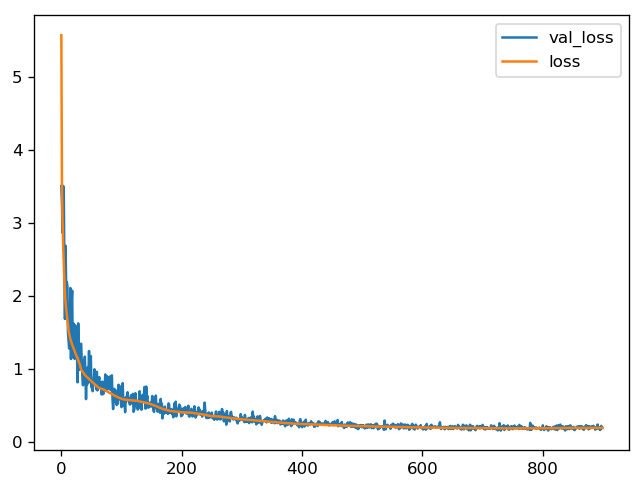

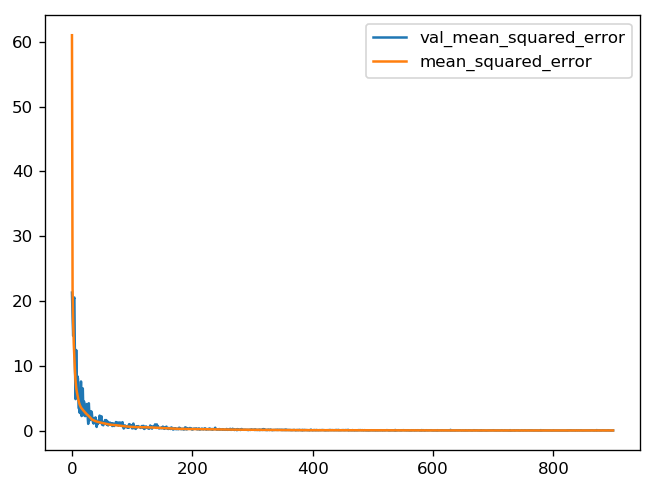

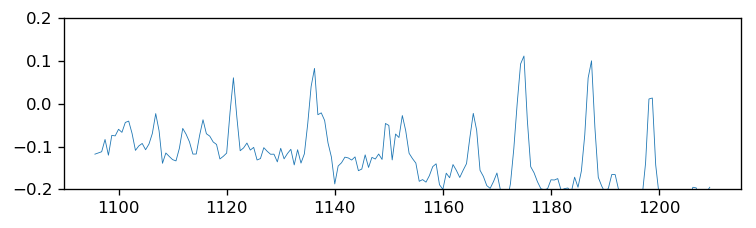

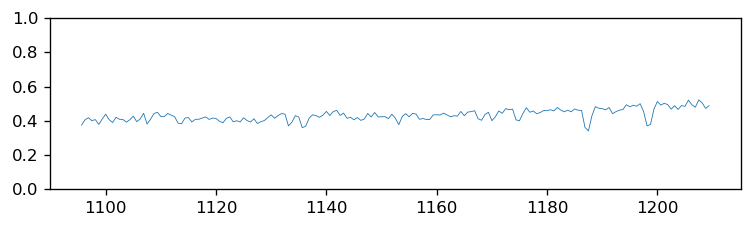

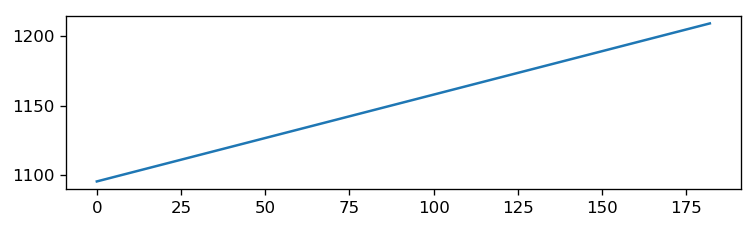

In [29]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(713, activation='relu', input_shape=(713,)))
    model.add(layers.Dense(713, activation='relu'))
    model.add(layers.Dense(183))
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mse'])
    return model
model = build_model()
print(model.summary())


num_epochs = 900
batch_size = 256
history = model.fit(train_X_count, train_Y_count, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X_count, test_Y_count))
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.legend()

wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

test_rad = np.array(test_Y_count)
test_tbb = rad2tbb(test_rad, wavenumber_Y)

prediction_rad = model.predict(test_X_count)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

idx = np.where(prediction_rad<0)
print(len(idx[0]))

bias_tbb = prediction_tbb - test_tbb

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.mean(axis=0), lw=0.5)
plt.ylim(-0.2, 0.2)
plt.tight_layout()
plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.std(axis=0), lw=0.5)
plt.ylim(0, 1)
plt.tight_layout()

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(np.arange(len(wavenumber_Y)), wavenumber_Y)
# plt.ylim(0, 1)
plt.tight_layout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 713)               509082    
_________________________________________________________________
dense_8 (Dense)              (None, 713)               509082    
_________________________________________________________________
dense_9 (Dense)              (None, 183)               130662    
Total params: 1,148,826
Trainable params: 1,148,826
Non-trainable params: 0
_________________________________________________________________
None
Train on 641079 samples, validate on 160269 samples
Epoch 1/900
641079/641079 [==============================] - 17s 27us/step - loss: 0.9534 - mean_squared_error: 12.4469 - val_loss: 0.3679 - val_mean_squared_error: 0.2307
Epoch 2/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.3318 - mean_squared_error: 0.1961 - val_loss: 0.3561 - val_mean_squared_error: 0.2

641079/641079 [==============================] - 16s 25us/step - loss: 0.1516 - mean_squared_error: 0.0397 - val_loss: 0.1481 - val_mean_squared_error: 0.0382
Epoch 45/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1519 - mean_squared_error: 0.0397 - val_loss: 0.1575 - val_mean_squared_error: 0.0418
Epoch 46/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1491 - mean_squared_error: 0.0383 - val_loss: 0.1527 - val_mean_squared_error: 0.0399
Epoch 47/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1472 - mean_squared_error: 0.0373 - val_loss: 0.1504 - val_mean_squared_error: 0.0388
Epoch 48/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1478 - mean_squared_error: 0.0376 - val_loss: 0.1584 - val_mean_squared_error: 0.0417
Epoch 49/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1467 - mean_squared_error: 0.0371 - val_loss: 0.1391 - val_mean_squ

Epoch 92/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1389 - mean_squared_error: 0.0330 - val_loss: 0.1491 - val_mean_squared_error: 0.0406
Epoch 93/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1385 - mean_squared_error: 0.0329 - val_loss: 0.1384 - val_mean_squared_error: 0.0332
Epoch 94/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1386 - mean_squared_error: 0.0329 - val_loss: 0.1501 - val_mean_squared_error: 0.0382
Epoch 95/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1394 - mean_squared_error: 0.0333 - val_loss: 0.1403 - val_mean_squared_error: 0.0334
Epoch 96/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1383 - mean_squared_error: 0.0328 - val_loss: 0.1361 - val_mean_squared_error: 0.0320
Epoch 97/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1391 - mean_squared_error: 0.0331 - val_loss: 0.1398 -

641079/641079 [==============================] - 16s 25us/step - loss: 0.1356 - mean_squared_error: 0.0315 - val_loss: 0.1359 - val_mean_squared_error: 0.0321
Epoch 140/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1357 - mean_squared_error: 0.0315 - val_loss: 0.1438 - val_mean_squared_error: 0.0345
Epoch 141/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1358 - mean_squared_error: 0.0316 - val_loss: 0.1427 - val_mean_squared_error: 0.0342
Epoch 142/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1355 - mean_squared_error: 0.0314 - val_loss: 0.1439 - val_mean_squared_error: 0.0351
Epoch 143/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1357 - mean_squared_error: 0.0315 - val_loss: 0.1412 - val_mean_squared_error: 0.0334
Epoch 144/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1372 - mean_squared_error: 0.0324 - val_loss: 0.1398 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1348 - mean_squared_error: 0.0311 - val_loss: 0.1394 - val_mean_squared_error: 0.0332
Epoch 187/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1337 - mean_squared_error: 0.0306 - val_loss: 0.1423 - val_mean_squared_error: 0.0335
Epoch 188/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1340 - mean_squared_error: 0.0307 - val_loss: 0.1338 - val_mean_squared_error: 0.0307
Epoch 189/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1332 - mean_squared_error: 0.0304 - val_loss: 0.1415 - val_mean_squared_error: 0.0329
Epoch 190/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1336 - mean_squared_error: 0.0305 - val_loss: 0.1412 - val_mean_squared_error: 0.0339
Epoch 191/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1334 - mean_squared_error: 0.0304 - val_loss: 0.1457 - val_mea

641079/641079 [==============================] - 16s 26us/step - loss: 0.1323 - mean_squared_error: 0.0299 - val_loss: 0.1397 - val_mean_squared_error: 0.0338
Epoch 234/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1323 - mean_squared_error: 0.0299 - val_loss: 0.1332 - val_mean_squared_error: 0.0308
Epoch 235/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1322 - mean_squared_error: 0.0299 - val_loss: 0.1343 - val_mean_squared_error: 0.0310
Epoch 236/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1321 - mean_squared_error: 0.0298 - val_loss: 0.1341 - val_mean_squared_error: 0.0314
Epoch 237/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1323 - mean_squared_error: 0.0299 - val_loss: 0.1357 - val_mean_squared_error: 0.0314
Epoch 238/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1326 - mean_squared_error: 0.0300 - val_loss: 0.1371 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1317 - mean_squared_error: 0.0296 - val_loss: 0.1423 - val_mean_squared_error: 0.0336
Epoch 281/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1316 - mean_squared_error: 0.0296 - val_loss: 0.1319 - val_mean_squared_error: 0.0300
Epoch 282/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1310 - mean_squared_error: 0.0293 - val_loss: 0.1329 - val_mean_squared_error: 0.0303
Epoch 283/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1315 - mean_squared_error: 0.0295 - val_loss: 0.1322 - val_mean_squared_error: 0.0298
Epoch 284/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1313 - mean_squared_error: 0.0294 - val_loss: 0.1352 - val_mean_squared_error: 0.0312
Epoch 285/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1312 - mean_squared_error: 0.0294 - val_loss: 0.1363 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1308 - mean_squared_error: 0.0292 - val_loss: 0.1353 - val_mean_squared_error: 0.0309
Epoch 328/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1306 - mean_squared_error: 0.0291 - val_loss: 0.1379 - val_mean_squared_error: 0.0323
Epoch 329/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1307 - mean_squared_error: 0.0292 - val_loss: 0.1293 - val_mean_squared_error: 0.0289
Epoch 330/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1309 - mean_squared_error: 0.0292 - val_loss: 0.1335 - val_mean_squared_error: 0.0302
Epoch 331/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1318 - mean_squared_error: 0.0297 - val_loss: 0.1312 - val_mean_squared_error: 0.0298
Epoch 332/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1307 - mean_squared_error: 0.0292 - val_loss: 0.1322 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1300 - mean_squared_error: 0.0288 - val_loss: 0.1319 - val_mean_squared_error: 0.0298
Epoch 375/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1304 - mean_squared_error: 0.0290 - val_loss: 0.1320 - val_mean_squared_error: 0.0298
Epoch 376/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1300 - mean_squared_error: 0.0288 - val_loss: 0.1349 - val_mean_squared_error: 0.0307
Epoch 377/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1300 - mean_squared_error: 0.0288 - val_loss: 0.1294 - val_mean_squared_error: 0.0290
Epoch 378/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1303 - mean_squared_error: 0.0290 - val_loss: 0.1338 - val_mean_squared_error: 0.0301
Epoch 379/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1303 - mean_squared_error: 0.0289 - val_loss: 0.1282 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1295 - mean_squared_error: 0.0286 - val_loss: 0.1351 - val_mean_squared_error: 0.0311
Epoch 422/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1298 - mean_squared_error: 0.0288 - val_loss: 0.1301 - val_mean_squared_error: 0.0291
Epoch 423/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1299 - mean_squared_error: 0.0288 - val_loss: 0.1299 - val_mean_squared_error: 0.0288
Epoch 424/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1293 - mean_squared_error: 0.0285 - val_loss: 0.1318 - val_mean_squared_error: 0.0296
Epoch 425/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1297 - mean_squared_error: 0.0287 - val_loss: 0.1359 - val_mean_squared_error: 0.0315
Epoch 426/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1297 - mean_squared_error: 0.0286 - val_loss: 0.1360 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1291 - mean_squared_error: 0.0284 - val_loss: 0.1356 - val_mean_squared_error: 0.0313
Epoch 469/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1297 - mean_squared_error: 0.0286 - val_loss: 0.1321 - val_mean_squared_error: 0.0300
Epoch 470/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1289 - mean_squared_error: 0.0283 - val_loss: 0.1299 - val_mean_squared_error: 0.0290
Epoch 471/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1308 - mean_squared_error: 0.0304 - val_loss: 0.1317 - val_mean_squared_error: 0.0294
Epoch 472/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1290 - mean_squared_error: 0.0283 - val_loss: 0.1414 - val_mean_squared_error: 0.0327
Epoch 473/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1292 - mean_squared_error: 0.0284 - val_loss: 0.1354 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1288 - mean_squared_error: 0.0282 - val_loss: 0.1325 - val_mean_squared_error: 0.0299
Epoch 516/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1292 - mean_squared_error: 0.0284 - val_loss: 0.1295 - val_mean_squared_error: 0.0288
Epoch 517/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1288 - mean_squared_error: 0.0283 - val_loss: 0.1319 - val_mean_squared_error: 0.0296
Epoch 518/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1289 - mean_squared_error: 0.0283 - val_loss: 0.1438 - val_mean_squared_error: 0.0344
Epoch 519/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1288 - mean_squared_error: 0.0283 - val_loss: 0.1303 - val_mean_squared_error: 0.0291
Epoch 520/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1289 - mean_squared_error: 0.0283 - val_loss: 0.1375 - val_mea

641079/641079 [==============================] - 16s 24us/step - loss: 0.1284 - mean_squared_error: 0.0281 - val_loss: 0.1336 - val_mean_squared_error: 0.0302
Epoch 563/900
641079/641079 [==============================] - 16s 24us/step - loss: 0.1286 - mean_squared_error: 0.0281 - val_loss: 0.1282 - val_mean_squared_error: 0.0285
Epoch 564/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1284 - mean_squared_error: 0.0281 - val_loss: 0.1412 - val_mean_squared_error: 0.0330
Epoch 565/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1282 - mean_squared_error: 0.0280 - val_loss: 0.1296 - val_mean_squared_error: 0.0288
Epoch 566/900
641079/641079 [==============================] - 16s 24us/step - loss: 0.1287 - mean_squared_error: 0.0282 - val_loss: 0.1336 - val_mean_squared_error: 0.0304
Epoch 567/900
641079/641079 [==============================] - 16s 24us/step - loss: 0.1284 - mean_squared_error: 0.0281 - val_loss: 0.1320 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1281 - mean_squared_error: 0.0279 - val_loss: 0.1306 - val_mean_squared_error: 0.0291
Epoch 610/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1283 - mean_squared_error: 0.0281 - val_loss: 0.1327 - val_mean_squared_error: 0.0299
Epoch 611/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1280 - mean_squared_error: 0.0279 - val_loss: 0.1284 - val_mean_squared_error: 0.0285
Epoch 612/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1277 - mean_squared_error: 0.0278 - val_loss: 0.1288 - val_mean_squared_error: 0.0286
Epoch 613/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1284 - mean_squared_error: 0.0280 - val_loss: 0.1327 - val_mean_squared_error: 0.0299
Epoch 614/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1278 - mean_squared_error: 0.0278 - val_loss: 0.1346 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1282 - mean_squared_error: 0.0284 - val_loss: 0.1297 - val_mean_squared_error: 0.0283
Epoch 657/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1277 - mean_squared_error: 0.0277 - val_loss: 0.1347 - val_mean_squared_error: 0.0307
Epoch 658/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1274 - mean_squared_error: 0.0276 - val_loss: 0.1314 - val_mean_squared_error: 0.0295
Epoch 659/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1278 - mean_squared_error: 0.0278 - val_loss: 0.1350 - val_mean_squared_error: 0.0304
Epoch 660/900
641079/641079 [==============================] - 16s 24us/step - loss: 0.1279 - mean_squared_error: 0.0278 - val_loss: 0.1308 - val_mean_squared_error: 0.0291
Epoch 661/900
641079/641079 [==============================] - 16s 24us/step - loss: 0.1276 - mean_squared_error: 0.0277 - val_loss: 0.1300 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1273 - mean_squared_error: 0.0276 - val_loss: 0.1298 - val_mean_squared_error: 0.0290
Epoch 704/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1275 - mean_squared_error: 0.0276 - val_loss: 0.1329 - val_mean_squared_error: 0.0302
Epoch 705/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1274 - mean_squared_error: 0.0276 - val_loss: 0.1373 - val_mean_squared_error: 0.0312
Epoch 706/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1274 - mean_squared_error: 0.0276 - val_loss: 0.1316 - val_mean_squared_error: 0.0295
Epoch 707/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1283 - mean_squared_error: 0.0290 - val_loss: 0.1322 - val_mean_squared_error: 0.0299
Epoch 708/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1273 - mean_squared_error: 0.0276 - val_loss: 0.1314 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1274 - mean_squared_error: 0.0276 - val_loss: 0.1450 - val_mean_squared_error: 0.0352
Epoch 751/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1275 - mean_squared_error: 0.0280 - val_loss: 0.1284 - val_mean_squared_error: 0.0282
Epoch 752/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1271 - mean_squared_error: 0.0275 - val_loss: 0.1296 - val_mean_squared_error: 0.0287
Epoch 753/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1271 - mean_squared_error: 0.0274 - val_loss: 0.1329 - val_mean_squared_error: 0.0296
Epoch 754/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1275 - mean_squared_error: 0.0277 - val_loss: 0.1340 - val_mean_squared_error: 0.0303
Epoch 755/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1313 - mean_squared_error: 0.0438 - val_loss: 0.1326 - val_mea

641079/641079 [==============================] - 17s 26us/step - loss: 0.1272 - mean_squared_error: 0.0275 - val_loss: 0.1311 - val_mean_squared_error: 0.0293
Epoch 798/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1272 - mean_squared_error: 0.0275 - val_loss: 0.1278 - val_mean_squared_error: 0.0280
Epoch 799/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1272 - mean_squared_error: 0.0276 - val_loss: 0.1313 - val_mean_squared_error: 0.0296
Epoch 800/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1271 - mean_squared_error: 0.0274 - val_loss: 0.1307 - val_mean_squared_error: 0.0288
Epoch 801/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1269 - mean_squared_error: 0.0274 - val_loss: 0.1318 - val_mean_squared_error: 0.0298
Epoch 802/900
641079/641079 [==============================] - 16s 25us/step - loss: 0.1270 - mean_squared_error: 0.0274 - val_loss: 0.1348 - val_mea

641079/641079 [==============================] - 16s 25us/step - loss: 0.1271 - mean_squared_error: 0.0274 - val_loss: 0.1284 - val_mean_squared_error: 0.0281
Epoch 845/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1271 - mean_squared_error: 0.0274 - val_loss: 0.1296 - val_mean_squared_error: 0.0290
Epoch 846/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1267 - mean_squared_error: 0.0273 - val_loss: 0.1289 - val_mean_squared_error: 0.0287
Epoch 847/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1270 - mean_squared_error: 0.0275 - val_loss: 0.1309 - val_mean_squared_error: 0.0294
Epoch 848/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1269 - mean_squared_error: 0.0273 - val_loss: 0.1305 - val_mean_squared_error: 0.0295
Epoch 849/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1270 - mean_squared_error: 0.0274 - val_loss: 0.1317 - val_mea

641079/641079 [==============================] - 17s 26us/step - loss: 0.1267 - mean_squared_error: 0.0273 - val_loss: 0.1296 - val_mean_squared_error: 0.0285
Epoch 892/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1267 - mean_squared_error: 0.0273 - val_loss: 0.1340 - val_mean_squared_error: 0.0301
Epoch 893/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1268 - mean_squared_error: 0.0273 - val_loss: 0.1358 - val_mean_squared_error: 0.1069
Epoch 894/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1297 - mean_squared_error: 0.0407 - val_loss: 0.1299 - val_mean_squared_error: 0.0289
Epoch 895/900
641079/641079 [==============================] - 17s 26us/step - loss: 0.1261 - mean_squared_error: 0.0271 - val_loss: 0.1316 - val_mean_squared_error: 0.0291
Epoch 896/900
641079/641079 [==============================] - 16s 26us/step - loss: 0.1271 - mean_squared_error: 0.0274 - val_loss: 0.1351 - val_mea

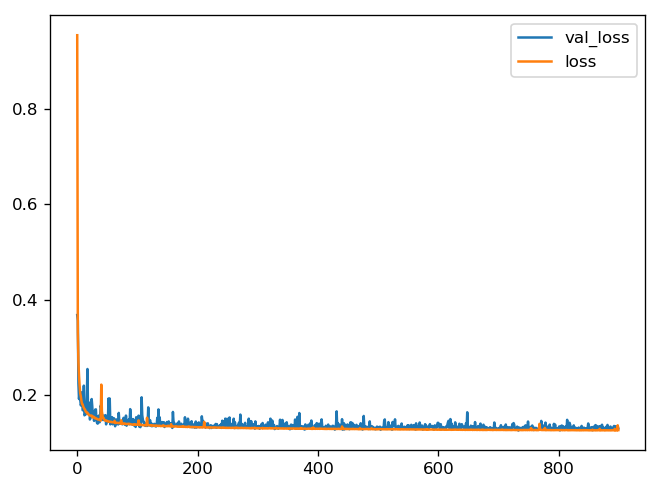

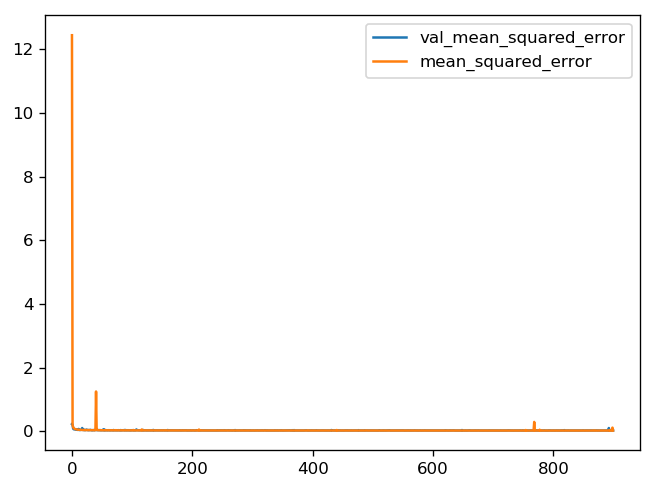

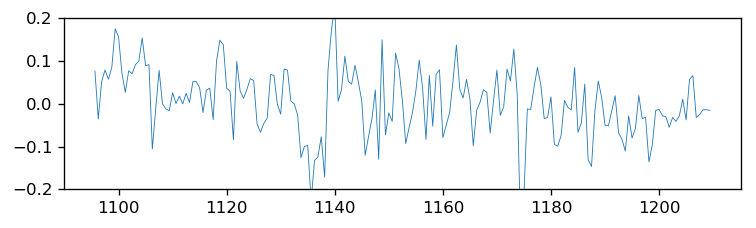

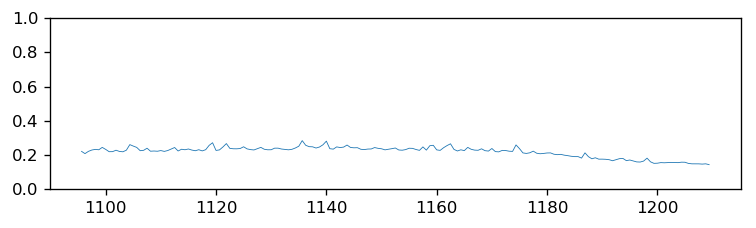

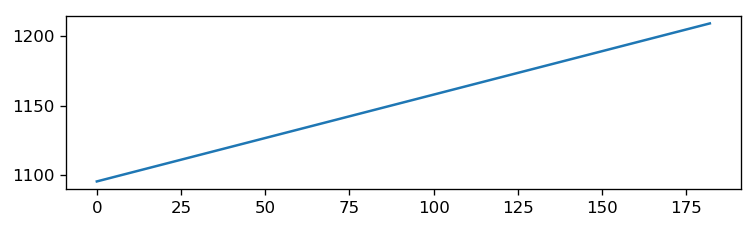

In [30]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(713, activation='elu', input_shape=(713,)))
    model.add(layers.Dense(713, activation='elu'))
    model.add(layers.Dense(183))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model
model = build_model()
print(model.summary())

num_epochs = 900
batch_size = 256
history = model.fit(train_X_count, train_Y_count, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X_count, test_Y_count))

plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.legend()

wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

test_rad = np.array(test_Y_count)
test_tbb = rad2tbb(test_rad, wavenumber_Y)

prediction_rad = model.predict(test_X_count)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

idx = np.where(prediction_rad<0)
print(len(idx[0]))

bias_tbb = prediction_tbb - test_tbb

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.mean(axis=0), lw=0.5)
plt.ylim(-0.2, 0.2)
plt.tight_layout()
plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.std(axis=0), lw=0.5)
plt.ylim(0, 1)
plt.tight_layout()

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(np.arange(len(wavenumber_Y)), wavenumber_Y)
# plt.ylim(0, 1)
plt.tight_layout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 713)               509082    
_________________________________________________________________
dense_11 (Dense)             (None, 713)               509082    
_________________________________________________________________
dense_12 (Dense)             (None, 713)               509082    
_________________________________________________________________
dense_13 (Dense)             (None, 713)               509082    
_________________________________________________________________
dense_14 (Dense)             (None, 713)               509082    
_________________________________________________________________
dense_15 (Dense)             (None, 183)               130662    
Total params: 2,676,072
Trainable params: 2,676,072
Non-trainable params: 0
_________________________________________________________________


Epoch 42/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1568 - mean_squared_error: 0.0420 - val_loss: 0.1753 - val_mean_squared_error: 0.0501
Epoch 43/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1625 - mean_squared_error: 0.0452 - val_loss: 0.1427 - val_mean_squared_error: 0.0354
Epoch 44/900
641079/641079 [==============================] - 25s 38us/step - loss: 0.1561 - mean_squared_error: 0.0415 - val_loss: 0.1626 - val_mean_squared_error: 1.3803
Epoch 45/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1589 - mean_squared_error: 0.0430 - val_loss: 0.1498 - val_mean_squared_error: 0.0391
Epoch 46/900
641079/641079 [==============================] - 25s 38us/step - loss: 0.1591 - mean_squared_error: 0.0454 - val_loss: 0.1416 - val_mean_squared_error: 0.0349
Epoch 47/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1575 - mean_squared_error: 0.0426 - val_loss: 0.1468 -

641079/641079 [==============================] - 25s 39us/step - loss: 0.1528 - mean_squared_error: 0.0401 - val_loss: 0.2007 - val_mean_squared_error: 0.0663
Epoch 90/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1508 - mean_squared_error: 0.0391 - val_loss: 0.1525 - val_mean_squared_error: 0.0400
Epoch 91/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1499 - mean_squared_error: 0.0385 - val_loss: 0.1414 - val_mean_squared_error: 0.0355
Epoch 92/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1500 - mean_squared_error: 0.0385 - val_loss: 0.1737 - val_mean_squared_error: 0.0511
Epoch 93/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1494 - mean_squared_error: 0.0382 - val_loss: 0.1676 - val_mean_squared_error: 0.0460
Epoch 94/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1479 - mean_squared_error: 0.0374 - val_loss: 0.1474 - val_mean_squ

641079/641079 [==============================] - 25s 39us/step - loss: 0.1544 - mean_squared_error: 0.0413 - val_loss: 0.1438 - val_mean_squared_error: 0.0364
Epoch 137/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1536 - mean_squared_error: 0.0407 - val_loss: 0.1879 - val_mean_squared_error: 0.0579
Epoch 138/900
641079/641079 [==============================] - 25s 38us/step - loss: 0.1504 - mean_squared_error: 0.0392 - val_loss: 0.1505 - val_mean_squared_error: 0.0392
Epoch 139/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1541 - mean_squared_error: 0.0411 - val_loss: 0.1457 - val_mean_squared_error: 0.0371
Epoch 140/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1488 - mean_squared_error: 0.0381 - val_loss: 0.1443 - val_mean_squared_error: 0.0365
Epoch 141/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1510 - mean_squared_error: 0.0393 - val_loss: 0.1493 - val_mea

641079/641079 [==============================] - 25s 39us/step - loss: 0.1404 - mean_squared_error: 0.0336 - val_loss: 0.1373 - val_mean_squared_error: 0.0324
Epoch 184/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1415 - mean_squared_error: 0.0342 - val_loss: 0.1415 - val_mean_squared_error: 0.0346
Epoch 185/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1407 - mean_squared_error: 0.0338 - val_loss: 0.1426 - val_mean_squared_error: 0.0348
Epoch 186/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1413 - mean_squared_error: 0.0341 - val_loss: 0.1357 - val_mean_squared_error: 0.0319
Epoch 187/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1413 - mean_squared_error: 0.0340 - val_loss: 0.1520 - val_mean_squared_error: 0.0379
Epoch 188/900
641079/641079 [==============================] - 25s 38us/step - loss: 0.1399 - mean_squared_error: 0.0334 - val_loss: 0.1384 - val_mea

641079/641079 [==============================] - 25s 39us/step - loss: 0.1412 - mean_squared_error: 0.0340 - val_loss: 0.1563 - val_mean_squared_error: 0.0406
Epoch 231/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1404 - mean_squared_error: 0.0337 - val_loss: 0.1631 - val_mean_squared_error: 0.0430
Epoch 232/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1410 - mean_squared_error: 0.0339 - val_loss: 0.1339 - val_mean_squared_error: 0.0313
Epoch 233/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1401 - mean_squared_error: 0.0335 - val_loss: 0.1376 - val_mean_squared_error: 0.0329
Epoch 234/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1407 - mean_squared_error: 0.0339 - val_loss: 0.1395 - val_mean_squared_error: 0.0434
Epoch 235/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1411 - mean_squared_error: 0.0340 - val_loss: 0.1516 - val_mea

641079/641079 [==============================] - 25s 39us/step - loss: 0.1451 - mean_squared_error: 0.0361 - val_loss: 0.1552 - val_mean_squared_error: 0.0405
Epoch 278/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1440 - mean_squared_error: 0.0356 - val_loss: 0.1441 - val_mean_squared_error: 0.0356
Epoch 279/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1464 - mean_squared_error: 0.0369 - val_loss: 0.1446 - val_mean_squared_error: 0.0360
Epoch 280/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1433 - mean_squared_error: 0.0352 - val_loss: 0.1536 - val_mean_squared_error: 0.0391
Epoch 281/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1438 - mean_squared_error: 0.0355 - val_loss: 0.1647 - val_mean_squared_error: 0.0449
Epoch 282/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1440 - mean_squared_error: 0.0356 - val_loss: 0.1517 - val_mea

641079/641079 [==============================] - 25s 39us/step - loss: 0.1374 - mean_squared_error: 0.0323 - val_loss: 0.1814 - val_mean_squared_error: 402.1638
Epoch 325/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1385 - mean_squared_error: 0.0328 - val_loss: 0.1968 - val_mean_squared_error: 446.3320
Epoch 326/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1379 - mean_squared_error: 0.0325 - val_loss: 0.1921 - val_mean_squared_error: 788.9869
Epoch 327/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1377 - mean_squared_error: 0.0324 - val_loss: 0.1467 - val_mean_squared_error: 4.0532
Epoch 328/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1385 - mean_squared_error: 0.0328 - val_loss: 0.2019 - val_mean_squared_error: 695.7266
Epoch 329/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1383 - mean_squared_error: 0.0327 - val_loss: 0.1742 -

Epoch 371/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1351 - mean_squared_error: 0.0312 - val_loss: 0.2614 - val_mean_squared_error: 3862.3118
Epoch 372/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1351 - mean_squared_error: 0.0312 - val_loss: 0.2792 - val_mean_squared_error: 3846.2218
Epoch 373/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1352 - mean_squared_error: 0.0312 - val_loss: 0.2965 - val_mean_squared_error: 6021.5337
Epoch 374/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1360 - mean_squared_error: 0.0315 - val_loss: 0.2991 - val_mean_squared_error: 6245.0582
Epoch 375/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1359 - mean_squared_error: 0.0316 - val_loss: 0.2847 - val_mean_squared_error: 5190.5091
Epoch 376/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1350 - mean_squared_error: 0.0311

641079/641079 [==============================] - 25s 39us/step - loss: 0.1342 - mean_squared_error: 0.0307 - val_loss: 0.3968 - val_mean_squared_error: 15571.4631
Epoch 418/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1345 - mean_squared_error: 0.0309 - val_loss: 0.4128 - val_mean_squared_error: 17484.2915
Epoch 419/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1338 - mean_squared_error: 0.0306 - val_loss: 0.4115 - val_mean_squared_error: 17029.4249
Epoch 420/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1337 - mean_squared_error: 0.0305 - val_loss: 0.3607 - val_mean_squared_error: 10772.9638
Epoch 421/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1345 - mean_squared_error: 0.0308 - val_loss: 0.3785 - val_mean_squared_error: 13112.6589
Epoch 422/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1338 - mean_squared_error: 0.0306 - val_lo

641079/641079 [==============================] - 25s 39us/step - loss: 0.1331 - mean_squared_error: 0.0302 - val_loss: 0.3651 - val_mean_squared_error: 11878.2934
Epoch 464/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1326 - mean_squared_error: 0.0300 - val_loss: 0.3987 - val_mean_squared_error: 15746.7252
Epoch 465/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1329 - mean_squared_error: 0.0301 - val_loss: 0.4682 - val_mean_squared_error: 23877.8520
Epoch 466/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1345 - mean_squared_error: 0.0310 - val_loss: 0.3708 - val_mean_squared_error: 12429.2513
Epoch 467/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1327 - mean_squared_error: 0.0300 - val_loss: 0.4449 - val_mean_squared_error: 22149.6361
Epoch 468/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1332 - mean_squared_error: 0.0303 - val_lo

641079/641079 [==============================] - 25s 39us/step - loss: 0.1326 - mean_squared_error: 0.0299 - val_loss: 0.3249 - val_mean_squared_error: 8888.3036
Epoch 510/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1331 - mean_squared_error: 0.0302 - val_loss: 0.3793 - val_mean_squared_error: 15642.6243
Epoch 511/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1325 - mean_squared_error: 0.0301 - val_loss: 0.3005 - val_mean_squared_error: 6876.5941
Epoch 512/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1331 - mean_squared_error: 0.0301 - val_loss: 0.3541 - val_mean_squared_error: 10680.5756
Epoch 513/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.3054 - mean_squared_error: 6253.0936 - val_loss: 0.2886 - val_mean_squared_error: 0.1474
Epoch 514/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.2032 - mean_squared_error: 115.5285 - val_los

641079/641079 [==============================] - 25s 39us/step - loss: 0.1353 - mean_squared_error: 0.0314 - val_loss: 4.3118 - val_mean_squared_error: 2740853.7292
Epoch 556/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1354 - mean_squared_error: 0.0314 - val_loss: 3.8639 - val_mean_squared_error: 1831614.5946
Epoch 557/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1354 - mean_squared_error: 0.0314 - val_loss: 5.2305 - val_mean_squared_error: 3539441.3173
Epoch 558/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1350 - mean_squared_error: 0.0312 - val_loss: 4.5541 - val_mean_squared_error: 2615482.1050
Epoch 559/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1349 - mean_squared_error: 0.0312 - val_loss: 4.7817 - val_mean_squared_error: 2647222.9813
Epoch 560/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1352 - mean_squared_error: 0.031

Epoch 601/900
641079/641079 [==============================] - 25s 39us/step - loss: 5.9684 - mean_squared_error: 15528334.6953 - val_loss: 0.2511 - val_mean_squared_error: 2.6937
Epoch 602/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.2207 - mean_squared_error: 0.1066 - val_loss: 0.7456 - val_mean_squared_error: 61024.3868
Epoch 603/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1882 - mean_squared_error: 0.0714 - val_loss: 0.9858 - val_mean_squared_error: 112134.7138
Epoch 604/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1773 - mean_squared_error: 0.0630 - val_loss: 1.7410 - val_mean_squared_error: 577737.7880
Epoch 605/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1734 - mean_squared_error: 0.0582 - val_loss: 1.6398 - val_mean_squared_error: 508267.9420
Epoch 606/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1727 - mean_squared_er

Epoch 648/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1468 - mean_squared_error: 0.0377 - val_loss: 0.1425 - val_mean_squared_error: 0.0359
Epoch 649/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1453 - mean_squared_error: 0.0370 - val_loss: 0.1552 - val_mean_squared_error: 0.0412
Epoch 650/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1458 - mean_squared_error: 0.0372 - val_loss: 0.1615 - val_mean_squared_error: 0.0439
Epoch 651/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1451 - mean_squared_error: 0.0368 - val_loss: 0.1417 - val_mean_squared_error: 0.0356
Epoch 652/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1452 - mean_squared_error: 0.0369 - val_loss: 0.1439 - val_mean_squared_error: 0.0366
Epoch 653/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1453 - mean_squared_error: 0.0369 - val_loss: 0.

641079/641079 [==============================] - 25s 39us/step - loss: 0.1419 - mean_squared_error: 0.0353 - val_loss: 0.1446 - val_mean_squared_error: 0.0365
Epoch 696/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1420 - mean_squared_error: 0.0353 - val_loss: 0.1640 - val_mean_squared_error: 0.0462
Epoch 697/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1414 - mean_squared_error: 0.0351 - val_loss: 0.1420 - val_mean_squared_error: 0.0356
Epoch 698/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1419 - mean_squared_error: 0.0353 - val_loss: 0.1444 - val_mean_squared_error: 0.0371
Epoch 699/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1413 - mean_squared_error: 0.0350 - val_loss: 0.1488 - val_mean_squared_error: 0.0383
Epoch 700/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1422 - mean_squared_error: 0.0354 - val_loss: 0.1412 - val_mea

641079/641079 [==============================] - 25s 39us/step - loss: 0.1406 - mean_squared_error: 0.0346 - val_loss: 0.1420 - val_mean_squared_error: 0.0389
Epoch 743/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1412 - mean_squared_error: 0.0349 - val_loss: 0.1478 - val_mean_squared_error: 1.6419
Epoch 744/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1409 - mean_squared_error: 0.0348 - val_loss: 0.1417 - val_mean_squared_error: 0.0382
Epoch 745/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1407 - mean_squared_error: 0.0347 - val_loss: 0.1441 - val_mean_squared_error: 2.3347
Epoch 746/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1407 - mean_squared_error: 0.0347 - val_loss: 0.1472 - val_mean_squared_error: 0.1457
Epoch 747/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1416 - mean_squared_error: 0.0351 - val_loss: 0.1512 - val_mea

641079/641079 [==============================] - 25s 39us/step - loss: 0.1404 - mean_squared_error: 0.0345 - val_loss: 0.1869 - val_mean_squared_error: 341.0917
Epoch 790/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1404 - mean_squared_error: 0.0345 - val_loss: 0.1723 - val_mean_squared_error: 76.2807
Epoch 791/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1401 - mean_squared_error: 0.0344 - val_loss: 0.2064 - val_mean_squared_error: 297.9995
Epoch 792/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1405 - mean_squared_error: 0.0346 - val_loss: 0.2749 - val_mean_squared_error: 1641.3268
Epoch 793/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1403 - mean_squared_error: 0.0345 - val_loss: 0.2685 - val_mean_squared_error: 2371.6364
Epoch 794/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1400 - mean_squared_error: 0.0343 - val_loss: 0.142

Epoch 836/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1422 - mean_squared_error: 0.0354 - val_loss: 1.3038 - val_mean_squared_error: 233466.0097
Epoch 837/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1417 - mean_squared_error: 0.0352 - val_loss: 0.3040 - val_mean_squared_error: 5514.6744
Epoch 838/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1423 - mean_squared_error: 0.0355 - val_loss: 0.1582 - val_mean_squared_error: 20.8988
Epoch 839/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1413 - mean_squared_error: 0.0350 - val_loss: 0.1662 - val_mean_squared_error: 0.0484
Epoch 840/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1412 - mean_squared_error: 0.0350 - val_loss: 0.1448 - val_mean_squared_error: 1.4220
Epoch 841/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1412 - mean_squared_error: 0.0350 - val

641079/641079 [==============================] - 25s 39us/step - loss: 0.1404 - mean_squared_error: 0.0345 - val_loss: 0.1572 - val_mean_squared_error: 0.0439
Epoch 884/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1399 - mean_squared_error: 0.0344 - val_loss: 0.2733 - val_mean_squared_error: 3545.1794
Epoch 885/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1405 - mean_squared_error: 0.0346 - val_loss: 0.1687 - val_mean_squared_error: 0.0598
Epoch 886/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1403 - mean_squared_error: 0.0345 - val_loss: 0.1460 - val_mean_squared_error: 0.0374
Epoch 887/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1400 - mean_squared_error: 0.0344 - val_loss: 0.1550 - val_mean_squared_error: 0.2633
Epoch 888/900
641079/641079 [==============================] - 25s 39us/step - loss: 0.1398 - mean_squared_error: 0.0343 - val_loss: 0.1459 - val_

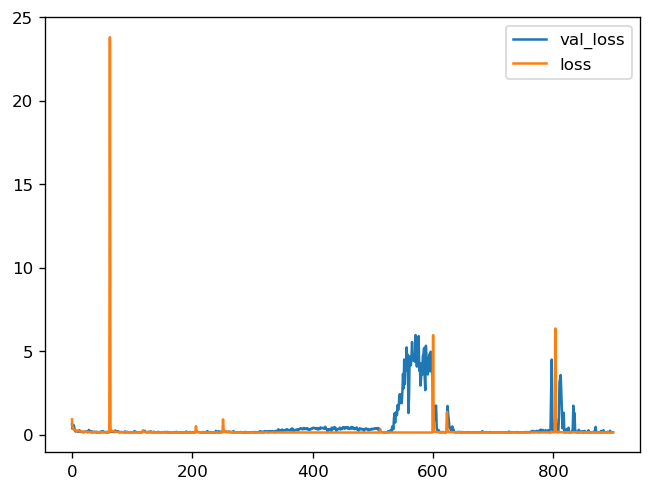

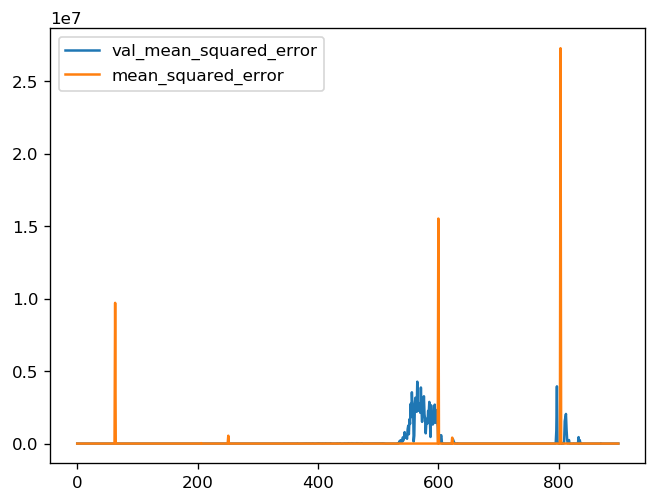

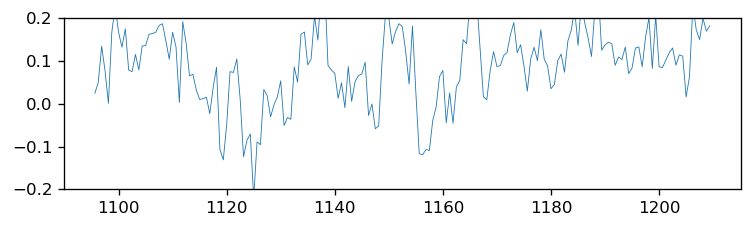

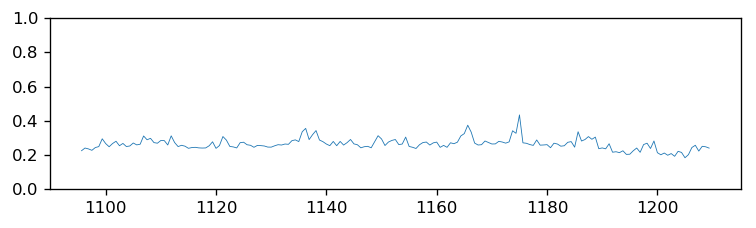

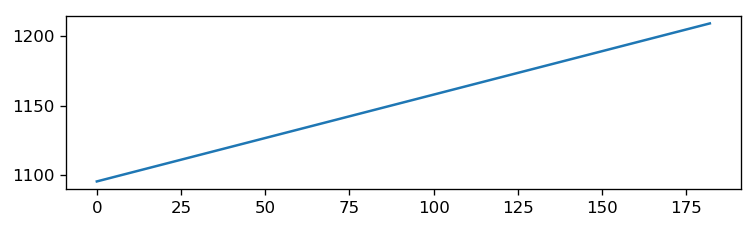

In [31]:
def build_model(X_col, Y_col):
    model = models.Sequential()
    model.add(layers.Dense(X_col, activation='elu', input_shape=(X_col,)))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(Y_col))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model
model = build_model(X_col, Y_col)
print(model.summary())

num_epochs = 900
batch_size = 256
history = model.fit(train_X_count, train_Y_count, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X_count, test_Y_count))
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.legend()

wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

test_rad = np.array(test_Y_count)
test_tbb = rad2tbb(test_rad, wavenumber_Y)

prediction_rad = model.predict(test_X_count)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

idx = np.where(prediction_rad<0)
print(len(idx[0]))

bias_tbb = prediction_tbb - test_tbb

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.mean(axis=0), lw=0.5)
plt.ylim(-0.2, 0.2)
plt.tight_layout()
plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.std(axis=0), lw=0.5)
plt.ylim(0, 1)
plt.tight_layout()

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(np.arange(len(wavenumber_Y)), wavenumber_Y)
# plt.ylim(0, 1)
plt.tight_layout()

In [ ]:
def build_model(X_col, Y_col):
    model = models.Sequential()
    model.add(layers.Dense(X_col, activation='elu', input_shape=(X_col,)))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(X_col, activation='elu'))
    model.add(layers.Dense(Y_col))
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    return model
model = build_model(X_col, Y_col)
print(model.summary())

num_epochs = 1000
batch_size = 256
history = model.fit(train_X_count, train_Y_count, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X_count, test_Y_count))
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.ylim(0.05, 0.2)
plt.legend()
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.ylim(0, 0.1)
plt.legend()

In [15]:
wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

test_rad = np.array(test_Y_count)
test_tbb = rad2tbb(test_rad, wavenumber_Y)

prediction_rad = model.predict(test_X_count)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

idx = np.where(prediction_rad<0)
print(len(idx[0]))

bias_tbb = prediction_tbb - test_tbb

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.mean(axis=0), lw=0.5)
plt.ylim(-0.2, 0.2)
plt.tight_layout()
plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(wavenumber_Y, bias_tbb.std(axis=0), lw=0.5)
plt.ylim(0, 1)
plt.tight_layout()

plt.figure(figsize=(6.4, 2), dpi=120)
plt.plot(np.arange(len(wavenumber_Y)), wavenumber_Y)
# plt.ylim(0, 1)
plt.tight_layout()

0


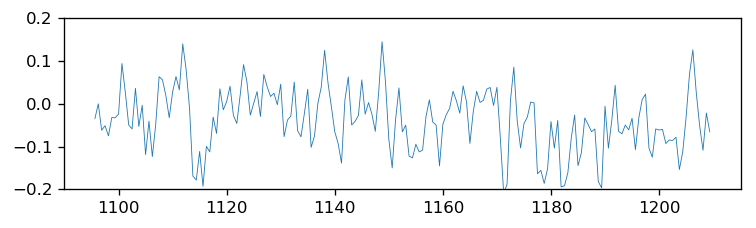

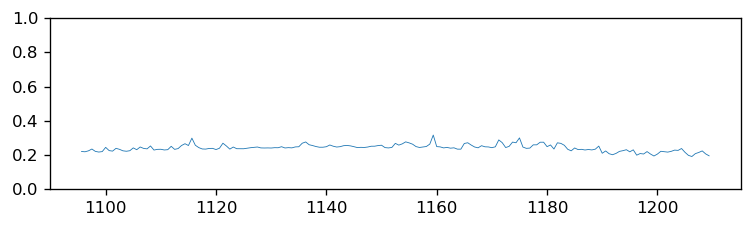

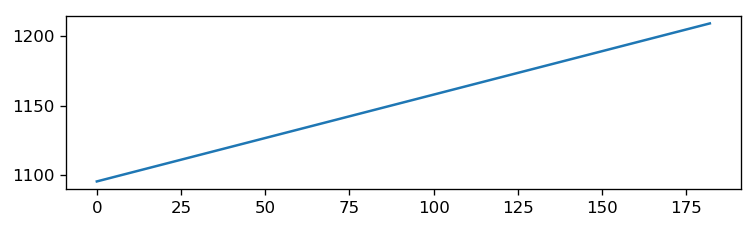

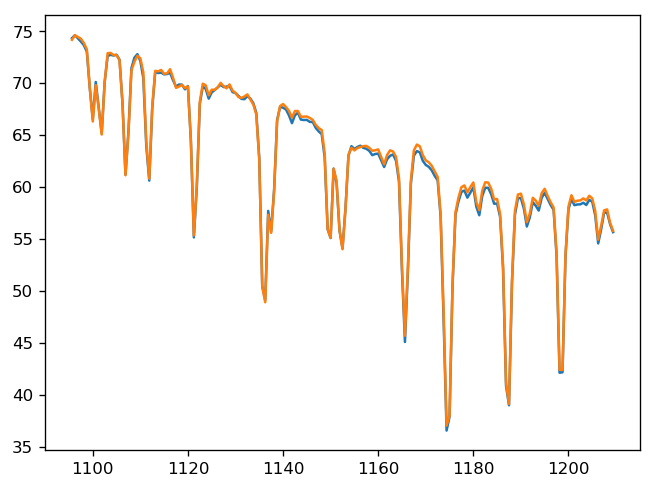

In [38]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(wavenumber_Y, test_rad[0])
plt.plot(wavenumber_Y, prediction_rad[0])

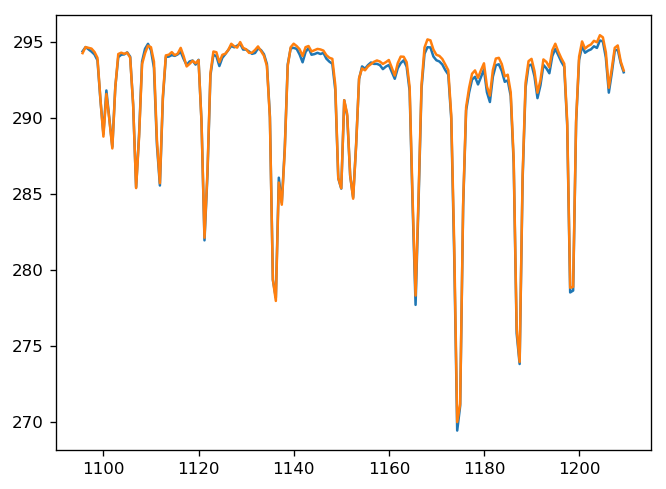

In [36]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.plot(wavenumber_Y, test_rad[0])
plt.plot(wavenumber_Y, prediction_tbb[0])